In [1]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time
import collections
import random
import math
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
%tensorflow_version 1.14

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
import keras 

from keras.layers import Lambda, Input, Dense, LSTM, SimpleRNN, GRU
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.regularizers import l1, l2
from keras.utils import np_utils, plot_model
from keras.layers import concatenate
from keras.layers.core import Reshape


import pydot
import tensorflow as tf
import os

Using TensorFlow backend.


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
## Set random seeds

seed_value= 1
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

import tensorflow as tf
tf.set_random_seed(seed_value)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [5]:
class One_Talking_No_Time_Best_World():

    def __init__(
        self, num_ent, winning_reward, talking_reward = 0, rand_state_size=1, non_unif_punishment=2, talking_action_size=3, action_size=3): #choose true or false
        ## TODO remove num ent, as it is the same as action size
        self.num_ent = num_ent # number of entities
        self.winning_reward = winning_reward
        self.talking_reward = talking_reward
        self.talking_decay = 0.995
        
        self.adv_len = 100
        
        self.actions1 = collections.deque(maxlen=self.adv_len)
        self.actions2 = collections.deque(maxlen=self.adv_len)

        self.phrases = collections.deque(maxlen=self.adv_len)
        
        self.rand_state_size = rand_state_size
        self.non_unif_punishment = non_unif_punishment

        self.talking_action_size = talking_action_size
        self.action_size = action_size
    
    def get_adversarial_means(self):
        # for teacher actions
        
        onehot_actions = np.zeros((self.adv_len, self.action_size)) 
        
        if len(self.actions1):

          onehot_actions[np.arange(len(self.actions1)), self.actions1] = 1
        
        mean_actions = np.mean(onehot_actions, axis=0)

        return mean_actions
        
    def initialize(self):
        ag1_input = np.random.random(self.rand_state_size) #UNIFORM/bimodal NOISE
        ag1_input = np.hstack([ag1_input, self.get_adversarial_means()])

        return ag1_input

    def communicate(self, ag1_message):

        self.phrases.append(ag1_message)

        ag2_input = np.zeros(self.talking_action_size)
        ag2_input[ag1_message] = 1

        return ag2_input
      

    def step(self, ag1_action, ag2_action):

        self.actions1.append(ag1_action)
        self.actions2.append(ag2_action)
        a1_rew = 0
        a2_rew = 0
        
        
        if len(self.actions1) > self.adv_len - 1:
            a1_rew = ((1/self.num_ent) - self.actions1.count(ag1_action) / self.adv_len) * self.non_unif_punishment
            a2_rew = ((1/self.num_ent) - self.actions2.count(ag2_action) / self.adv_len) * self.non_unif_punishment

            a1_rew += ((1/self.talking_action_size) - self.phrases.count(self.phrases[-1]) / self.adv_len) * self.non_unif_punishment

            #a1_rew = a1_rew if a1_rew < 0 else 0
            #a2_rew = a2_rew if a2_rew < 0 else 0
            
        if ag2_action == ag1_action:
            reward1 = self.winning_reward + a1_rew
            reward2 = self.winning_reward + a2_rew
            
        else:
            reward1 = a1_rew#-1
            reward2 = a2_rew#-1
                            
        return(reward1, reward2)

In [6]:
# Deep Q-learning Agent
class DQNAgent_2_fake_teacher:
    def __init__(self, state_size, talking_action_size, choices):
        self.state_size = state_size
        self.memory = collections.deque(maxlen=11)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.3
        self.epsilon_decay = 0.999
        self.learning_rate_bad = 0.0001
        self.learning_rate_good = 0.0001
 
        self.talking_action_size = talking_action_size
        self.choices = choices
   
    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
                           
    def act(self, state):
       
        assert self.choices == self.talking_action_size, "Fake agent assumes equal sizes of communication and action spaces"
 
        choice = random.randrange(self.choices)
 
        return [choice, choice] # Todo - if different sizes of blah
                           
    def replay(self, batch_size):

      return
 
 
# Deep Q-learning Agent
class DQNAgent_2_fake_student:
    def __init__(self, state_size, talking_action_size, choices):
        self.state_size = state_size
        self.memory = collections.deque(maxlen=100)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.3
        self.epsilon_decay = 0.999
        self.learning_rate_bad = 0.0001
        self.learning_rate_good = 0.01
 
        self.talking_action_size = talking_action_size
        self.choices = choices
        
    def remember(self, state, action, reward, next_state):

        self.memory.append((state, action, reward, next_state))
                           
    def act(self, state):
       
        #assert self.choices == self.talking_action_size, "Fake agent assumes equal sizes of communication and action spaces"
 
        # if np.all(state < 0.5):
        #   return self.choices
        choice = np.argmax(state)
 
        return choice # Todo - if different sizes of blah
                           
    def replay(self, batch_size):
        
        pass

In [7]:
class DQNAgent_2_new:
    def __init__(self, state_size, talking_action_size, choices, lr=0.0001, decay=0, is_teacher=False):
        self.state_size = state_size
        self.memory = collections.deque(maxlen=5)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.0
        self.epsilon_decay = 0.9999
        self.learning_rate_bad = lr
        self.learning_rate_good = 0.0001

        self.decay = decay
 
        self.talking_action_size = talking_action_size
        self.choices = choices

        self.is_teacher = is_teacher
        self.model = self._build_model()

    
    def _build_model_teacher(self):
        # Neural Net for Deep-Q learning Model        
        assert self.talking_action_size > 0, "Zero talking for teacher"
        t = 1
       
        model = Sequential()
        
        model.add(Dense(15, input_dim=self.state_size + self.talking_action_size + self.choices, activation='relu'))
        model.add(Dense(15, activation='relu'))
 
        model.add(Dense(self.choices, activation='linear'))
        #model.compile(loss='mse', optimizer=SGD(lr=self.learning_rate_bad, decay=self.decay))
        #model.compile(loss='mse',
        #             optimizer=Adam(lr=self.learning_rate_bad, beta_1=0.05, beta_2=0.95))
        model.compile(loss='mse',
                     optimizer=Adam(lr=self.learning_rate_bad))
        return model
     
    def _build_model_student(self):
        # Neural Net for Deep-Q learning Model
 
        #assert self.talking_action_size == 0, "Student model called with nonzero talking action size"
 
        model = Sequential()
        model.add(Dense(15, input_dim=self.talking_action_size, activation='relu'))
        model.add(Dense(15, activation='relu'))
       
        model.add(Dense(self.choices, activation='linear'))
        #model.compile(loss='mse', optimizer=SGD(lr=self.learning_rate_bad, decay=self.decay))
        
        #model.compile(loss='mse',
        #              optimizer=Adam(lr=self.learning_rate_bad, beta_1=0.05, beta_2=0.95))
        model.compile(loss='mse',
                     optimizer=Adam(lr=self.learning_rate_bad))
        return model
 
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
       
        if self.is_teacher:
            return self._build_model_teacher()
        else:
            return self._build_model_student()
 
    def remember(self, state, action, reward, next_state):

        self.memory.append((state, action, reward, next_state))
                           
    def act(self, state):
 
        ### Exploration
        if np.random.rand() <= self.epsilon:
            if not self.is_teacher:
                return random.randrange(self.choices)
            else:
                return [random.randrange(self.talking_action_size), random.randrange(self.choices)]
 
        ### Acting for student
        if not self.is_teacher:
                     
            state = np.expand_dims(state, axis=0)
            act_values = self.model.predict(state, batch_size=1)
 
            return np.argmax(act_values[0])  # returns choice from 0 to n-1
 
 
        # Acting for teacher
        else:
 
          max_q = -float("infinity")
          max_talk = None
          max_action = None
 
          for i in range(self.talking_action_size):
 
            talking = np.zeros(self.talking_action_size)
            talking[i] = 1
 
            state_cur = np.expand_dims(np.hstack([state, talking]), axis=0)
 
            act_values = self.model.predict(state_cur, batch_size=1)
 
            cur_max = np.max(act_values)
           
            if cur_max > max_q:
 
              max_q = cur_max
              max_action = np.argmax(act_values[0])
              max_talk = i
 
          assert max_talk is not None
          assert max_action is not None
 
          return [max_talk, max_action]
                           
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)

        target_fs = np.zeros((batch_size, self.choices))

        if self.is_teacher:
            cur_states = np.zeros((batch_size, self.state_size + self.choices + self.talking_action_size))
        else:
            cur_states = np.zeros((batch_size, self.talking_action_size))
                                                              # For Teacher                                # For student                                                                # For the teacher (receiving adv history)
        #cur_states = np.zeros((batch_size, self.state_size * (1 if self.talking_action_size > 0 else 0) + (self.talking_action_size) * (1 if self.talking_action_size == 0 else 0) + (self.choices) * (1 if self.talking_action_size > 0 else 0)))
        
        for i, (state, action, reward, next_state) in enumerate(minibatch):
            #next_state = np.expand_dims(next_state, axis=0)
            state = np.expand_dims(state, axis=0)
            target = reward

            if self.is_teacher: # If this is a teacher

                talking = np.zeros(self.talking_action_size)
                talking[action[0]] = 1
                cur_state = np.hstack([state, talking[np.newaxis]])

                target_f = self.model.predict(cur_state, batch_size=1)
                target_f[0][action[1]] = target
                target_fs[i] = target_f
                cur_states[i] = cur_state
                
            else:

                # one_hot_talk = np.zeros(self.talking_action_size)
                # print(one_hot_talk.shape)
                # print(action)
                # one_hot_talk[action[0]] = 1
                #print(state.shape)
                cur_state = state
                #cur_state = np.hstack([state, one_hot_talk[np.state_size, talking_action_size, choicesnewaxis]])
                cur_states[i] = cur_state
 
                target_f = self.model.predict(cur_state, batch_size=1)

                target_f[0][action] = target # choose
                target_fs[i] = target_f[0]

        self.model.train_on_batch(cur_states, target_fs)
 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [8]:
def add_choice_history(action_hist_array_a1, talk_hist_array, a1_talk, a1_act, a2_act, i):
  num_talking_options = action_hist_array.shape[1]
  num_actions = talk_hist_array.shape[1]

  for a in range(num_actions):
    action_hist_array[i, j] = np.mean(np.array(a1_act[-50:]) == a) # change 50 to horizon?
  

def prep_proportion_plot(chosen_options, num_options, horizon=50):

  chosen_options = np.array(chosen_options)
  ohe = OneHotEncoder(categories=[np.arange(num_options)], sparse=False)
  opts_onehot = ohe.fit_transform(chosen_options.reshape(-1, 1))

  action_hist_proportion = np.zeros((opts_onehot.shape[0] - horizon + 1, num_options))

  for i in range(num_options):
    action_hist_proportion[:, i] = np.convolve(opts_onehot[:, i], np.ones((horizon,)) / horizon, mode='valid')

  return action_hist_proportion

def make_plots(scores_1, scores_2, a1_talk, a1_act, a2_act, num_actions, num_phrases, horizon=50):
        ## Assumes no compositionality

        a1_talk, a1_act, a2_act = np.array(a1_talk), np.array(a1_act), np.array(a2_act)
                
        ## Chosen action history

        action_hist = prep_proportion_plot(a1_act, num_actions)
        plt.figure()
        plt.plot(action_hist)
        plt.legend(["Action {}".format(i) for i in range(num_actions)])
        plt.title("action proportions (agent 1)")

        ## Chosen action history

        action_hist = prep_proportion_plot(a2_act, num_actions)
        plt.figure()
        plt.plot(action_hist)
        plt.legend(["Action {}".format(i) for i in range(num_actions)])
        plt.title("action proportions (agent 2)")

        ## Chosen correct action history

        action_hist = prep_proportion_plot(a1_act[a1_act==a2_act], num_actions)
        plt.figure()
        plt.plot(np.arange(a1_act.shape[0])[a1_act==a2_act][:-horizon+1], action_hist)
        plt.legend(["Action {}".format(i) for i in range(4)])
        plt.title("action proportions when won")

        ## Chosen talk history

        talk_hist = prep_proportion_plot(a1_talk, num_phrases)
        plt.figure()
        plt.plot(talk_hist)
        plt.legend(["Phrase {}".format(i) for i in range(num_phrases)])
        plt.title("Phrase proportions")

        ## Chosen talk history when won

        talk_hist = prep_proportion_plot(a1_talk[a1_act==a2_act], num_phrases)
        plt.figure()
        plt.plot(np.arange(a1_talk.shape[0])[a1_act==a2_act][:-horizon+1], talk_hist)
        plt.legend(["Phrase {}".format(i) for i in range(num_phrases)])
        plt.title("Phrase proportions when won")

        ## Actions when specific phrase

        for i in range(num_phrases):

          plt.figure()
          act_hist = prep_proportion_plot(a1_act[a1_talk==i], num_actions)
          plt.figure()
          plt.plot(np.arange(a1_act.shape[0])[a1_talk == i][:-horizon + 1], act_hist)
          plt.legend(["Action {}".format(i) for i in range(num_phrases)])
          plt.title("Action proportions for agent 1 when message is {}".format(i))

          plt.figure()
          act_hist = prep_proportion_plot(a2_act[a1_talk == i], num_actions)
          plt.figure()
          plt.plot(np.arange(a2_act.shape[0])[a1_talk==i][:-horizon + 1], act_hist)
          plt.legend(["Action {}".format(i) for i in range(num_phrases)])
          plt.title("Action proportions for agent 2 when  message is {}".format(i))



# Run experiments

In [9]:
#agent1 = DQNAgent_2_fake_teacher(1, 4, 4) # can talk
agent2 = DQNAgent_2_fake_student(4, 0, 3)

rand_state_size = 3
#state_size, talking_action_size, choices
agent1 = DQNAgent_2_new(rand_state_size, talking_action_size=4, choices=4, lr=1e-5, is_teacher=True) # can talk
#agent2 = DQNAgent_2_new(rand_state_size, talking_action_size=4, choices=4, lr=1e-5, is_teacher=False) # Student does not use random input, actually

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
#num_ent, winning_reward, talking_reward
env = One_Talking_No_Time_Best_World(4, 1, 0, rand_state_size=rand_state_size, non_unif_punishment=4, talking_action_size=4, action_size=4)

In [11]:
# Iterate the game
episodes = 100000
a1_talk = []
a1_act = []
a2 = []
scores1 = []
scores2 = []

wins = 1
loses = 1

for e in range(episodes):
    score1 = 0
    score2 = 0
    
    #state1, state2, _, _ = env.step(0, 0, 0) # 4 - doing nothing 
    state1 = env.initialize()
    
    # agent 1 talks
    action1 = agent1.act(state1)
    
    state2 = env.communicate(action1[0])    
    action2 = agent2.act(state2)
    
    # receive rewards
    reward1, reward2 = env.step(action1[1], action2)     
        
    score1 += reward1
    score2 += reward2

    #adv_state = env.get_adversarial_means()
       # Next state not used
    #print("state 1 shape: {}, state 2 shape: {}".format(state1.shape, state2.shape))
    #print(state1)
    #print(action1)
    
    #agent1.remember(state1, action1, reward1, next_state1)
    #agent2.remember(state2, action2, reward2, next_state2)
    agent1.remember(state1, action1, reward1, None)
    agent2.remember(state2, action2, reward2, None)

    if e % 500 == 0:
      print("episode: {}/{}, mean score1: {}, mean score2: {}"
                  .format(e, episodes, np.mean(scores1[-500:]), np.mean(scores2[-500:])))
    if len(agent1.memory) >= 5 and len(agent2.memory) >= 5: 
        #if wins/loses < np.random.uniform(0,2):   
        agent1.replay(5)
        agent2.replay(5)
    
    a1_talk.append(action1[0])
    a1_act.append(action1[1])
    a2.append(action2)
    scores1.append(score1)
    scores2.append(score2)

episode: 0/100000, mean score1: nan, mean score2: nan


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



episode: 500/100000, mean score1: 0.19304, mean score2: 0.22
episode: 1000/100000, mean score1: 0.17359999999999998, mean score2: 0.2024
episode: 1500/100000, mean score1: 0.22087999999999997, mean score2: 0.26215999999999995
episode: 2000/100000, mean score1: 0.21023999999999995, mean score2: 0.26544
episode: 2500/100000, mean score1: 0.24919999999999995, mean score2: 0.29591999999999996
episode: 3000/100000, mean score1: 0.23488, mean score2: 0.28512
episode: 3500/100000, mean score1: 0.24807999999999997, mean score2: 0.31584
episode: 4000/100000, mean score1: 0.18431999999999998, mean score2: 0.32015999999999994
episode: 4500/100000, mean score1: 0.24679999999999996, mean score2: 0.35312
episode: 5000/100000, mean score1: 0.20088, mean score2: 0.29575999999999997
episode: 5500/100000, mean score1: 0.216, mean score2: 0.36584000000000005
episode: 6000/100000, mean score1: 0.23832, mean score2: 0.37744
episode: 6500/100000, mean score1: 0.21136, mean score2: 0.27912
episode: 7000/100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


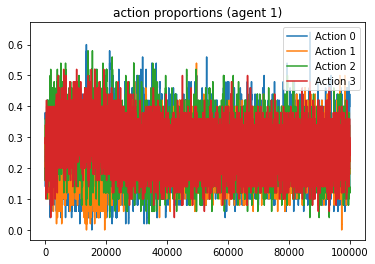

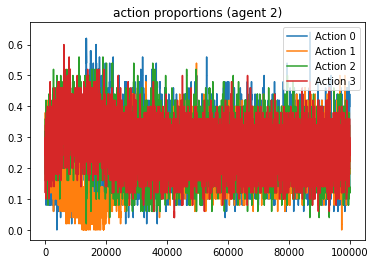

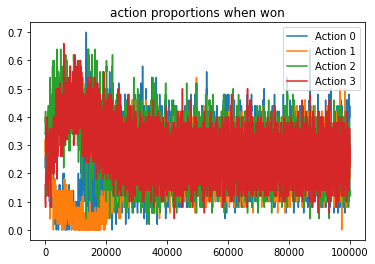

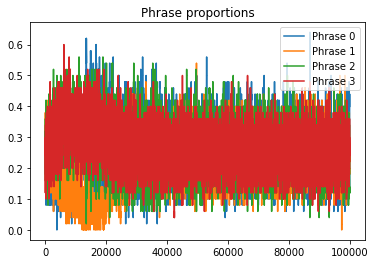

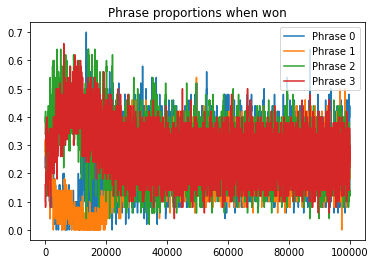

<Figure size 432x288 with 0 Axes>

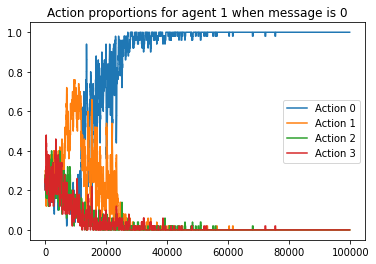

<Figure size 432x288 with 0 Axes>

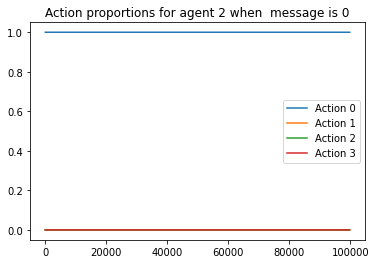

<Figure size 432x288 with 0 Axes>

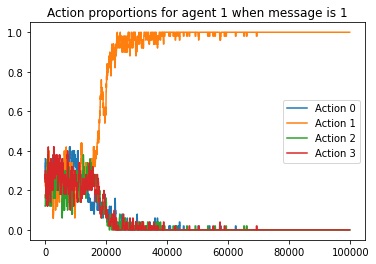

<Figure size 432x288 with 0 Axes>

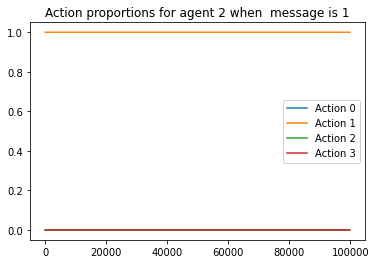

<Figure size 432x288 with 0 Axes>

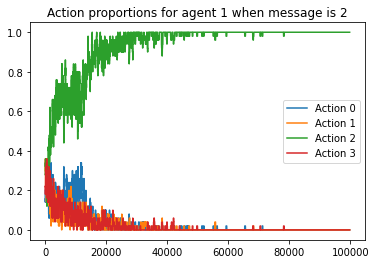

<Figure size 432x288 with 0 Axes>

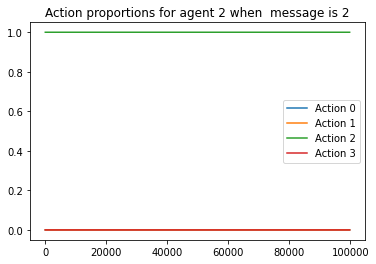

<Figure size 432x288 with 0 Axes>

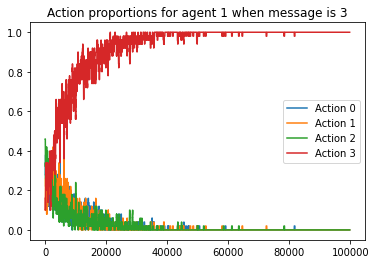

<Figure size 432x288 with 0 Axes>

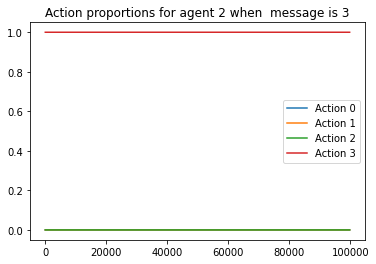

In [12]:
make_plots(scores1, scores2, a1_talk, a1_act, a2, 4, 4, 50)


Text(0, 0.5, 'Mean score 100 episodes')

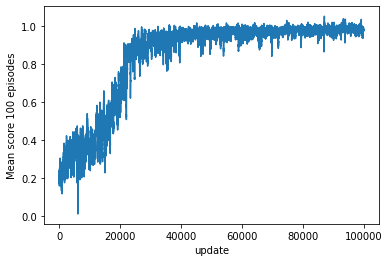

In [13]:
label = "{}"

plt.plot(np.convolve(scores2, np.ones((100,)) / 100, mode='valid'))
plt.xlabel("update")
plt.ylabel("Mean score 100 episodes")